In [1]:
# Built-in
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, GlobalAveragePooling2D, LSTM, Dense, Dropout
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

In [2]:
# Define the path to the dataset
base_path = r'C:\Users\3\Desktop\Dataset\faceplus_processed_research_final_2_crop'
categories = ['fake', 'real']
# ==========================
# ĐỊNH NGHĨA ĐƯỜNG DẪN DATA
# ==========================
# Initialize a list to hold data
data = []

# Process each category
for category in categories:
    category_path = os.path.join(base_path, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.jpg'):
            try:
                id_part, frame_part = filename.split('_frame_')
                id_ = id_part.split('_')[0]
                frame = frame_part.split('.')[0]
                data.append({
                    'filename': filename,
                    'path': os.path.join(category_path, filename),
                    'id': int(id_),
                    'frame': int(frame),
                    'label': category
                })
            except ValueError:
                continue

# Convert the data to a DataFrame
df = pd.DataFrame(data)
df['label_id'] = df['label'].map({'fake': 0, 'real': 1})
df

df['video_key'] = df['id'].astype(str) + "_" + df['label']

from collections import defaultdict

video_dict = defaultdict(list)
labels = {}

for _, row in df.iterrows():
    key = row['video_key']
    video_dict[key].append(row['path'])
    labels[key] = row['label_id']



In [3]:
df

,filename,path,id,frame,label,label_id,video_key
0,000_003_frame_0000.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,0,0,fake,0,0_fake
1,000_003_frame_0001.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,0,1,fake,0,0_fake
2,000_003_frame_0002.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,0,2,fake,0,0_fake
3,000_003_frame_0003.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,0,3,fake,0,0_fake
4,000_003_frame_0004.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,0,4,fake,0,0_fake
...,...,...,...,...,...,...,...
59803,999_frame_0025.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,999,25,real,1,999_real
59804,999_frame_0026.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,999,26,real,1,999_real
59805,999_frame_0027.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,999,27,real,1,999_real
59806,999_frame_0028.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,999,28,real,1,999_real


In [4]:
# ================================================
# ĐỌC CSV FUSION: FFT + DCT + SRM + OPENFACE
# THAY THẾ CHO CSV OPENFACE CŨ
# ================================================
from sklearn.preprocessing import StandardScaler

print("📂 Loading merged FFT + DCT + SRM + OpenFace features from CSV files...")

# Path đến CSV fusion: FFT + DCT + SRM + OpenFace (fake / real)
# LƯU Ý: thêm .csv ở cuối (sửa lại cho đúng với máy bạn nếu cần)
csv_fake_path = r'C:\Users\3\Desktop\Dataset\Fusion-frequency-openface-FF\merge_frequency_openface_features_fake_FFDataset.csv'
csv_real_path = r'C:\Users\3\Desktop\Dataset\Fusion-frequency-openface-FF\merge_frequency_openface_features_real_FFDataset.csv'

# Kiểm tra tồn tại
if not os.path.exists(csv_fake_path):
    raise FileNotFoundError(f"Không tìm thấy file: {csv_fake_path}")
if not os.path.exists(csv_real_path):
    raise FileNotFoundError(f"Không tìm thấy file: {csv_real_path}")

# Đọc 2 file CSV fake / real
df_fake_features = pd.read_csv(csv_fake_path)
df_real_features = pd.read_csv(csv_real_path)

# Gộp chung
df_all_features = pd.concat([df_fake_features, df_real_features], ignore_index=True)

# Đảm bảo cột filename đúng tên
df_all_features.rename(columns={df_all_features.columns[0]: 'filename'}, inplace=True)

# Các cột metadata KHÔNG đưa vào vector feature
non_feature_cols = [
    'filename',
    'width', 'height', 'color_mode', 'resize_to', 'do_hann'
]
non_feature_cols = [c for c in non_feature_cols if c in df_all_features.columns]

# Tất cả cột còn lại là feature: SRM + DCT + FFT + OpenFace (feature_1..feature_674, v.v.)
feature_cols = [c for c in df_all_features.columns if c not in non_feature_cols]

print(f"✅ Tổng số feature columns (SRM + DCT + FFT + OpenFace): {len(feature_cols)}")

# Tạo dict: filename -> vector feature (fusion)
csv_features = {}
for _, row in df_all_features.iterrows():
    filename = row['filename']
    feats = row[feature_cols].values.astype('float32')
    csv_features[filename] = feats

csv_feature_dim = len(feature_cols)
print(f"✅ Loaded {len(csv_features)} fused feature vectors")
print(f"✅ Each fused vector has {csv_feature_dim} dimensions")
print(f"✅ Feature dictionary ready for 1-to-1 frame mapping")



📂 Loading merged FFT + DCT + SRM + OpenFace features from CSV files...
✅ Tổng số feature columns (SRM + DCT + FFT + OpenFace): 952
✅ Loaded 59808 fused feature vectors
✅ Each fused vector has 952 dimensions
✅ Feature dictionary ready for 1-to-1 frame mapping


In [5]:
# ======================================================
# 3. IMPORT BỔ SUNG & CẤU HÌNH MÔ HÌNH
# ======================================================

import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (
    Input, TimeDistributed, LSTM, Dropout, Dense, GlobalAveragePooling2D, 
    Concatenate, BatchNormalization, Bidirectional, Attention, Flatten
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from hmmlearn.hmm import GaussianHMM
from tfkan.layers import Conv2DKAN, DenseKAN
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler

# Configuration (same as before)
video_keys = list(video_dict.keys())
video_labels = [labels[k] for k in video_keys]

img_size = (224, 224)
batch_size = 32
epochs = 50
n_splits = 5
sequence_len = 10
results = []
all_histories = []


In [6]:
# ======================================================
# 4. CHUẨN HÓA FUSION CSV FEATURES
# ======================================================

print("🔧 Computing CSV feature statistics for normalization...")
all_csv_features = []
for key in video_keys:
    frames = video_dict[key][:sequence_len]
    for path in frames:
        filename = os.path.basename(path)
        if filename in csv_features:
            all_csv_features.append(csv_features[filename])

if len(all_csv_features) == 0:
    raise RuntimeError("Không có mẫu nào khớp giữa tên file ảnh và CSV fusion (csv_features). Kiểm tra lại 'filename' trong CSV và folder ảnh.")

csv_scaler = StandardScaler()
csv_scaler.fit(all_csv_features)
print(f"✅ CSV feature normalization fitted on {len(all_csv_features)} samples")


🔧 Computing CSV feature statistics for normalization...
✅ CSV feature normalization fitted on 19982 samples


In [7]:
# ======================================================
# 5. DATA GENERATOR: VIDEOSEQUENCE
# ======================================================

class VideoSequence(tf.keras.utils.Sequence):
    def __init__(self, video_keys, video_dict, labels, batch_size, img_size, sequence_len=10, augment=False):
        self.video_keys = video_keys
        self.video_dict = video_dict
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_len = sequence_len
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15 if augment else 0,
            zoom_range=0.1 if augment else 0,
            horizontal_flip=augment
        )

    def __len__(self):
        return int(np.ceil(len(self.video_keys) / self.batch_size))

    def __getitem__(self, idx):
        batch_keys = self.video_keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X_img, batch_X_csv, batch_y = [], [], []

        for key in batch_keys:
            frames = self.video_dict[key][:self.sequence_len]
            imgs = []
            csv_feats = []
            
            for path in frames:
                # Load and process image
                img = cv2.imread(path)
                img = cv2.resize(img, self.img_size)
                img = self.datagen.random_transform(img) if self.augment else img
                img = img.astype('float32') / 255.0
                imgs.append(img)
                
                # Load FUSION CSV features (1-to-1 mapping)
                filename = os.path.basename(path)
                if filename in csv_features:
                    csv_feat = csv_features[filename]
                    csv_feat = csv_scaler.transform([csv_feat])[0]
                else:
                    csv_feat = np.zeros(csv_feature_dim, dtype='float32')
                csv_feats.append(csv_feat)
            
            # Pad sequences if needed
            while len(imgs) < self.sequence_len:
                imgs.append(np.zeros((*self.img_size, 3), dtype='float32'))
                csv_feats.append(np.zeros(csv_feature_dim, dtype='float32'))
            
            batch_X_img.append(imgs)
            batch_X_csv.append(csv_feats)
            batch_y.append(self.labels[key])

        return [np.array(batch_X_img), np.array(batch_X_csv)], np.array(batch_y)


In [8]:
# ======================================================
# 6. MÔ HÌNH BiLSTM + ATTENTION + KAN
# ======================================================

def build_model(sequence_len, img_size, csv_dim=674):
    # MobileNet branch
    base_cnn = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights='imagenet')
    base_cnn.trainable = True
    for layer in base_cnn.layers[:-20]:
        layer.trainable = False
    
    cnn_out = GlobalAveragePooling2D()(base_cnn.output)
    cnn_model = Model(inputs=base_cnn.input, outputs=cnn_out)
    
    # Image sequence input
    input_seq_img = Input(shape=(sequence_len, *img_size, 3), name='image_input')
    x_img = TimeDistributed(cnn_model)(input_seq_img)
    
    # CSV features input
    input_seq_csv = Input(shape=(sequence_len, csv_dim), name='csv_input')
    
    # BatchNormalization before fusion
    x_img = BatchNormalization(name='bn_mobilenet')(x_img)
    x_csv = BatchNormalization(name='bn_csv')(input_seq_csv)
    
    # Concatenate features (1-to-1 fusion)
    x_combined = Concatenate(axis=-1, name='feature_fusion')([x_img, x_csv])
    
    # BiLSTM layers
    x = Bidirectional(LSTM(128, return_sequences=True, name='bilstm_1'))(x_combined)
    x = Dropout(0.3, name='dropout_1')(x)
    x = Bidirectional(LSTM(64, return_sequences=True, name='bilstm_2'))(x)
    x = Dropout(0.3, name='dropout_2')(x)
    
    # Attention mechanism
    attn_output = Attention(name='attention')([x, x])
    # Global average pooling over time dimension to get fixed-size output
    x = tf.keras.layers.GlobalAveragePooling1D(name='global_avg_pool')(attn_output)
    x = Dropout(0.2, name='dropout_attention')(x)
    
    # Classification layers
    x = Dense(64, activation='relu', name='dense_1')(x)
    x = Dropout(0.2, name='dropout_3')(x)
    x = Dense(32, activation='relu', name='dense_2')(x)
    x = Dropout(0.2, name='dropout_4')(x)
    
    # KAN output layer
    x = DenseKAN(1, name='kan_output')(x)
    output = tf.keras.activations.sigmoid(x)
    
    model = Model(inputs=[input_seq_img, input_seq_csv], outputs=output, name='BiLSTM_Attention_KAN')
    return model

# ======================================================
# 7. HMM POST-PROCESSING
# ======================================================

def hmm_postprocess(pred_probs, y_true, n_states=2):
    pred_probs = pred_probs.reshape(-1, 1)
    hmm = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
    hmm.fit(pred_probs)
    hidden_states = hmm.predict(pred_probs)

    mapping = {}
    for state in np.unique(hidden_states):
        indices = [i for i in range(len(hidden_states)) if hidden_states[i] == state]
        state_labels = [y_true[i] for i in indices]
        if len(state_labels) > 0:
            mapped_label = mode(state_labels, keepdims=True).mode[0]
        else:
            mapped_label = 0
        mapping[state] = mapped_label

    hmm_labels = np.array([mapping[s] for s in hidden_states])
    return hmm_labels

# ======================================================
# 8. TRAINING K-FOLD
# ======================================================

print("\n🚀 Starting BiLSTM + Attention + KAN Training:")
print("   ✅ Bidirectional LSTM (128 + 64 units)")
print("   ✅ Keras Attention mechanism (robust)")
print("   ✅ Normalized FUSION features (1-to-1 mapping)")
print("   ✅ MobileNet (last 20 layers trainable)")
print("   ✅ KAN output layer")
print("   ✅ HMM post-processing\n")

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (trainval_idx, test_idx) in enumerate(skf.split(video_keys, video_labels), 1):
    print(f"\n{'='*60}")
    print(f"📊 Fold {fold}/{n_splits} - BiLSTM_Attention_KAN")
    print(f"{'='*60}")

    trainval_keys = [video_keys[i] for i in trainval_idx]
    test_keys = [video_keys[i] for i in test_idx]

    y_trainval = [labels[k] for k in trainval_keys]
    train_keys, val_keys = train_test_split(
        trainval_keys,
        test_size=0.1,
        stratify=y_trainval,
        random_state=fold
    )

    train_gen = VideoSequence(
        train_keys, video_dict, labels,
        batch_size, img_size, sequence_len,
        augment=True
    )
    val_gen = VideoSequence(
        val_keys, video_dict, labels,
        batch_size, img_size, sequence_len,
        augment=False
    )
    test_gen = VideoSequence(
        test_keys, video_dict, labels,
        batch_size, img_size, sequence_len,
        augment=False
    )

    model = build_model(sequence_len, img_size, csv_feature_dim)
    model.compile(optimizer=Adamax(3e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
    print(f"\n📈 Model Architecture:")
    print(f"   - Model: BiLSTM + Attention + KAN")
    print(f"   - Total params: {model.count_params():,}")
    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f"   - Trainable params: {trainable_params:,}")
    print(f"   - Learning rate: 3e-4")

    model_path = f"best_model_fold{fold}_bilstm_attn_kan.h5"
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[checkpoint, earlystop, reduce_lr],
        verbose=1
    )
    all_histories.append(history.history)

    model.load_weights(model_path)

    y_true = [labels[k] for k in test_keys]
    y_pred_prob = model.predict(test_gen).ravel()
    y_hmm_pred = hmm_postprocess(y_pred_prob, y_true)

    results.append({
        'fold': fold,
        'accuracy': accuracy_score(y_true, y_hmm_pred),
        'precision': precision_score(y_true, y_hmm_pred),
        'recall': recall_score(y_true, y_hmm_pred),
        'f1': f1_score(y_true, y_hmm_pred),
        'auc': roc_auc_score(y_true, y_pred_prob)
    })
    
    print(f"\n✅ Fold {fold} Results (BiLSTM_Attention_KAN):")
    print(f"   Accuracy:  {results[-1]['accuracy']:.4f}")
    print(f"   Precision: {results[-1]['precision']:.4f}")
    print(f"   Recall:    {results[-1]['recall']:.4f}")
    print(f"   F1 Score:  {results[-1]['f1']:.4f}")
    print(f"   AUC:       {results[-1]['auc']:.4f}")

print(f"\n{'='*60}")
print("📊 FINAL RESULTS - BiLSTM_Attention_KAN Model")
print(f"{'='*60}")
for r in results:
    print(f"Fold {r['fold']}: Acc={r['accuracy']:.4f}, "
          f"Prec={r['precision']:.4f}, Rec={r['recall']:.4f}, "
          f"F1={r['f1']:.4f}, AUC={r['auc']:.4f}")

print(f"\n📊 Average Metrics:")
results_df = pd.DataFrame(results)
print(results_df.mean(numeric_only=True))


🚀 Starting BiLSTM + Attention + KAN Training:
   ✅ Bidirectional LSTM (128 + 64 units)
   ✅ Keras Attention mechanism (robust)
   ✅ Normalized FUSION features (1-to-1 mapping)
   ✅ MobileNet (last 20 layers trainable)
   ✅ KAN output layer
   ✅ HMM post-processing


📊 Fold 1/5 - BiLSTM_Attention_KAN



📈 Model Architecture:
   - Model: BiLSTM + Attention + KAN
   - Total params: 4,859,937
   - Trainable params: 3,803,185
   - Learning rate: 3e-4
Epoch 1/50


45/45 [==============================] - ETA: 0s - loss: 0.6397 - accuracy: 0.6778
Epoch 1: val_accuracy improved from -inf to 0.80625, saving model to best_model_fold1_bilstm_attn_kan.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 274s 6s/step - loss: 0.6397 - accuracy: 0.6778 - val_loss: 0.5936 - val_accuracy: 0.8062 - lr: 3.0000e-04
Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 0.4504 - accuracy: 0.8229
Epoch 2: val_accuracy improved from 0.80625 to 0.83750, saving model to best_model_fold1_bilstm_attn_kan.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 241s 5s/step - loss: 0.4504 - accuracy: 0.8229 - val_loss: 0.4144 - val_accuracy: 0.8375 - lr: 3.0000e-04
Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 0.2916 - accuracy: 0.8889
Epoch 3: val_accuracy improved from 0.83750 to 0.89375, saving model to best_model_fold1_bilstm_attn_kan.h5
45/45 [==============================] - 240s 5s/step - loss: 0.2916 - accuracy: 0.8889 - val_loss: 0.3121 - val_accuracy: 0.8938 - lr: 3.0000e-04


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 4/50
45/45 [==============================] - ETA: 0s - loss: 0.1613 - accuracy: 0.9444
Epoch 4: val_accuracy improved from 0.89375 to 0.90000, saving model to best_model_fold1_bilstm_attn_kan.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 239s 5s/step - loss: 0.1613 - accuracy: 0.9444 - val_loss: 0.2436 - val_accuracy: 0.9000 - lr: 3.0000e-04
Epoch 5/50
45/45 [==============================] - ETA: 0s - loss: 0.0970 - accuracy: 0.9708
Epoch 5: val_accuracy did not improve from 0.90000
45/45 [==============================] - 241s 5s/step - loss: 0.0970 - accuracy: 0.9708 - val_loss: 0.2770 - val_accuracy: 0.8750 - lr: 3.0000e-04
Epoch 6/50
45/45 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9833
Epoch 6: val_accuracy did not improve from 0.90000
45/45 [==============================] - 241s 5s/step - loss: 0.0610 - accuracy: 0.9833 - val_loss: 0.3877 - val_accuracy: 0.8562 - lr: 3.0000e-04
Epoch 7/50
45/45 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9931
Epoch 7: val_accuracy did not improve from 0.90000

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
45/45 [==============================] - 240s 5

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



✅ Fold 1 Results (BiLSTM_Attention_KAN):
   Accuracy:  0.5000
   Precision: 0.0000
   Recall:    0.0000
   F1 Score:  0.0000
   AUC:       0.9286

📊 Fold 2/5 - BiLSTM_Attention_KAN

📈 Model Architecture:
   - Model: BiLSTM + Attention + KAN
   - Total params: 4,859,937
   - Trainable params: 3,803,185
   - Learning rate: 3e-4
Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 0.6288 - accuracy: 0.6569
Epoch 1: val_accuracy improved from -inf to 0.76875, saving model to best_model_fold2_bilstm_attn_kan.h5
45/45 [==============================] - 249s 5s/step - loss: 0.6288 - accuracy: 0.6569 - val_loss: 0.6032 - val_accuracy: 0.7688 - lr: 3.0000e-04


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 0.4805 - accuracy: 0.8389
Epoch 2: val_accuracy improved from 0.76875 to 0.77500, saving model to best_model_fold2_bilstm_attn_kan.h5
45/45 [==============================] - 239s 5s/step - loss: 0.4805 - accuracy: 0.8389 - val_loss: 0.5272 - val_accuracy: 0.7750 - lr: 3.0000e-04


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 0.3415 - accuracy: 0.8986
Epoch 3: val_accuracy improved from 0.77500 to 0.81250, saving model to best_model_fold2_bilstm_attn_kan.h5
45/45 [==============================] - 240s 5s/step - loss: 0.3415 - accuracy: 0.8986 - val_loss: 0.3923 - val_accuracy: 0.8125 - lr: 3.0000e-04


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 4/50
45/45 [==============================] - ETA: 0s - loss: 0.2096 - accuracy: 0.9431
Epoch 4: val_accuracy improved from 0.81250 to 0.83750, saving model to best_model_fold2_bilstm_attn_kan.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 241s 5s/step - loss: 0.2096 - accuracy: 0.9431 - val_loss: 0.3404 - val_accuracy: 0.8375 - lr: 3.0000e-04
Epoch 5/50
45/45 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.9653
Epoch 5: val_accuracy did not improve from 0.83750
45/45 [==============================] - 240s 5s/step - loss: 0.1207 - accuracy: 0.9653 - val_loss: 0.3779 - val_accuracy: 0.8250 - lr: 3.0000e-04
Epoch 6/50
45/45 [==============================] - ETA: 0s - loss: 0.0732 - accuracy: 0.9806
Epoch 6: val_accuracy did not improve from 0.83750
45/45 [==============================] - 240s 5s/step - loss: 0.0732 - accuracy: 0.9806 - val_loss: 0.6140 - val_accuracy: 0.7750 - lr: 3.0000e-04
Epoch 7/50
45/45 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 0.9882
Epoch 7: val_accuracy improved from 0.83750 to 0.85000, saving model to best_model_fold2_bilstm_attn_kan.h5

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00015000000

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0295 - accuracy: 0.9951
Epoch 8: val_accuracy improved from 0.85000 to 0.85625, saving model to best_model_fold2_bilstm_attn_kan.h5
45/45 [==============================] - 241s 5s/step - loss: 0.0295 - accuracy: 0.9951 - val_loss: 0.5246 - val_accuracy: 0.8562 - lr: 1.5000e-04
Epoch 9/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9979
Epoch 9: val_accuracy improved from 0.85625 to 0.86250, saving model to best_model_fold2_bilstm_attn_kan.h5
45/45 [==============================] - 241s 5s/step - loss: 0.0204 - accuracy: 0.9979 - val_loss: 0.5122 - val_accuracy: 0.8625 - lr: 1.5000e-04
Epoch 10/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9972
Epoch 10: val_accuracy improved from 0.86250 to 0.88125, saving model to best_model_fold2_bilstm_attn_kan.h5

Epoch 10: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 240s 5s/step - loss: 0.0188 - accuracy: 0.9972 - val_loss: 0.4655 - val_accuracy: 0.8813 - lr: 1.5000e-04
Epoch 11/50
45/45 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9986
Epoch 11: val_accuracy improved from 0.88125 to 0.90000, saving model to best_model_fold2_bilstm_attn_kan.h5
45/45 [==============================] - 240s 5s/step - loss: 0.0153 - accuracy: 0.9986 - val_loss: 0.4060 - val_accuracy: 0.9000 - lr: 7.5000e-05


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 12/50
45/45 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9986
Epoch 12: val_accuracy improved from 0.90000 to 0.90625, saving model to best_model_fold2_bilstm_attn_kan.h5
45/45 [==============================] - 241s 5s/step - loss: 0.0126 - accuracy: 0.9986 - val_loss: 0.3961 - val_accuracy: 0.9062 - lr: 7.5000e-05


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 13/50
45/45 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9986
Epoch 13: val_accuracy improved from 0.90625 to 0.91250, saving model to best_model_fold2_bilstm_attn_kan.h5

Epoch 13: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
45/45 [==============================] - 240s 5s/step - loss: 0.0120 - accuracy: 0.9986 - val_loss: 0.3861 - val_accuracy: 0.9125 - lr: 7.5000e-05
Epoch 14/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 1.0000
Epoch 14: val_accuracy did not improve from 0.91250
45/45 [==============================] - 240s 5s/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.3930 - val_accuracy: 0.9125 - lr: 3.7500e-05
Epoch 15/50
45/45 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 1.0000
Epoch 15: val_accuracy did not improve from 0.91250
45/45 [==============================] - 239s 5s/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.4005 - val_accuracy: 0.9062 - lr: 3.7500e-05
Epoch 16/50
45/45 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 1.0000
Epoch 16: val_accuracy did not improve from 0.91250

Epoch 16: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
45/45 [==============================] - 241s 5s/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.4141 - val_accuracy: 0.9000 - lr: 3.7500e-05
Epoch 17/50
45/45 [==============================] 

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 252s 5s/step - loss: 0.6494 - accuracy: 0.6347 - val_loss: 0.6486 - val_accuracy: 0.6562 - lr: 3.0000e-04
Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 0.5156 - accuracy: 0.8042
Epoch 2: val_accuracy improved from 0.65625 to 0.69375, saving model to best_model_fold3_bilstm_attn_kan.h5
45/45 [==============================] - 242s 5s/step - loss: 0.5156 - accuracy: 0.8042 - val_loss: 0.5612 - val_accuracy: 0.6938 - lr: 3.0000e-04


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 0.3499 - accuracy: 0.8847
Epoch 3: val_accuracy improved from 0.69375 to 0.83750, saving model to best_model_fold3_bilstm_attn_kan.h5
45/45 [==============================] - 244s 5s/step - loss: 0.3499 - accuracy: 0.8847 - val_loss: 0.4028 - val_accuracy: 0.8375 - lr: 3.0000e-04


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 4/50
45/45 [==============================] - ETA: 0s - loss: 0.2332 - accuracy: 0.9271
Epoch 4: val_accuracy did not improve from 0.83750
45/45 [==============================] - 242s 5s/step - loss: 0.2332 - accuracy: 0.9271 - val_loss: 0.4075 - val_accuracy: 0.7750 - lr: 3.0000e-04
Epoch 5/50
45/45 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.9590
Epoch 5: val_accuracy did not improve from 0.83750
45/45 [==============================] - 241s 5s/step - loss: 0.1483 - accuracy: 0.9590 - val_loss: 0.4241 - val_accuracy: 0.8188 - lr: 3.0000e-04
Epoch 6/50
45/45 [==============================] - ETA: 0s - loss: 0.0943 - accuracy: 0.9785
Epoch 6: val_accuracy did not improve from 0.83750

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
45/45 [==============================] - 243s 5s/step - loss: 0.0943 - accuracy: 0.9785 - val_loss: 0.6196 - val_accuracy: 0.7563 - lr: 3.0000e-04
Epoch 7/50
45/45 [=============================

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 0.4170 - accuracy: 0.8299
Epoch 2: val_accuracy improved from 0.73750 to 0.76250, saving model to best_model_fold4_bilstm_attn_kan.h5
45/45 [==============================] - 243s 5s/step - loss: 0.4170 - accuracy: 0.8299 - val_loss: 0.4763 - val_accuracy: 0.7625 - lr: 3.0000e-04


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 0.2776 - accuracy: 0.9035
Epoch 3: val_accuracy improved from 0.76250 to 0.80625, saving model to best_model_fold4_bilstm_attn_kan.h5
45/45 [==============================] - 245s 5s/step - loss: 0.2776 - accuracy: 0.9035 - val_loss: 0.4096 - val_accuracy: 0.8062 - lr: 3.0000e-04


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 4/50
45/45 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.9431
Epoch 4: val_accuracy improved from 0.80625 to 0.81250, saving model to best_model_fold4_bilstm_attn_kan.h5
45/45 [==============================] - 245s 5s/step - loss: 0.1769 - accuracy: 0.9431 - val_loss: 0.4042 - val_accuracy: 0.8125 - lr: 3.0000e-04


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 5/50
45/45 [==============================] - ETA: 0s - loss: 0.0999 - accuracy: 0.9729
Epoch 5: val_accuracy improved from 0.81250 to 0.82500, saving model to best_model_fold4_bilstm_attn_kan.h5
45/45 [==============================] - 243s 5s/step - loss: 0.0999 - accuracy: 0.9729 - val_loss: 0.5468 - val_accuracy: 0.8250 - lr: 3.0000e-04
Epoch 6/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0663 - accuracy: 0.9833
Epoch 6: val_accuracy improved from 0.82500 to 0.85000, saving model to best_model_fold4_bilstm_attn_kan.h5
45/45 [==============================] - 244s 5s/step - loss: 0.0663 - accuracy: 0.9833 - val_loss: 0.4585 - val_accuracy: 0.8500 - lr: 3.0000e-04
Epoch 7/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9903
Epoch 7: val_accuracy did not improve from 0.85000

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
45/45 [==============================] - 244s 5s/step - loss: 0.0397 - accuracy: 0.9903 - val_loss: 0.5639 - val_accuracy: 0.8500 - lr: 3.0000e-04
Epoch 8/50
45/45 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.9958
Epoch 8: val_accuracy improved from 0.85000 to 0.86250, saving model to best_model_fold4_bilstm_attn_kan.h5
45/45 [==============================] - 246s 5s/step - loss: 0.0252 - accuracy: 0.9958 - val_loss: 0.5499 - val_accuracy: 0.8625 - lr: 1.5000e-04
Epoch 9/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9986
Epoch 9: val_accuracy did not improve from 0.86250
45/45 [==============================] - 245s 5s/step - loss: 0.0194 - accuracy: 0.9986 - val_loss: 0.5780 - val_accuracy: 0.8562 - lr: 1.5000e-04
Epoch 10/50
45/45 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9986
Epoch 10: val_accuracy did not improve from 0.86250

Epoch 10: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
45/45 [==============================] - 243s 5s/step - loss: 0.0148 - accuracy: 0.9986 - val_loss: 0.5783 - val_accuracy: 0.8562 - lr: 1.5000e-04
Epoch 11/50
45/45 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 0.9986
Epoch 11: val_accuracy improved from 0.86250 to 0.86875, saving model to best_model_fold4_bilstm_attn_kan.h5
45/45 [==============================] - 245s 5s/step - loss: 0.0131 - accuracy: 0.9986 - val_loss: 0.5783 - val_accuracy: 0.8687 - lr: 7.5000e

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 12/50
45/45 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9986
Epoch 12: val_accuracy did not improve from 0.86875
45/45 [==============================] - 246s 5s/step - loss: 0.0123 - accuracy: 0.9986 - val_loss: 0.5978 - val_accuracy: 0.8687 - lr: 7.5000e-05
Epoch 13/50
45/45 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9986
Epoch 13: val_accuracy improved from 0.86875 to 0.88125, saving model to best_model_fold4_bilstm_attn_kan.h5

Epoch 13: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
45/45 [==============================] - 243s 5s/step - loss: 0.0122 - accuracy: 0.9986 - val_loss: 0.5997 - val_accuracy: 0.8813 - lr: 7.5000e-05
Epoch 14/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 0.9993
Epoch 14: val_accuracy improved from 0.88125 to 0.88750, saving model to best_model_fold4_bilstm_attn_kan.h5
45/45 [==============================] - 242s 5s/step - loss: 0.0102 - accuracy: 0.9993 - val_loss: 0.6098 - val_accuracy: 0.8875 - lr: 3.7500e-05
Epoch 15/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9986
Epoch 15: val_accuracy did not improve from 0.88750
45/45 [==============================] - 245s 5s/step - loss: 0.0095 - accuracy: 0.9986 - val_loss: 0.6324 - val_accuracy: 0.8875 - lr: 3.7500e-05
Epoch 16/50
45/45 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9993
Epoch 16: val_accuracy did not improve from 0.88750

Epoch 16: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
45/45 [==============================] - 246s 5s/step - loss: 0.0082 - accuracy: 0.9993 - val_loss: 0.6576 - val_accuracy: 0.8813 - lr: 3.7500e-05
Epoch 17/50
45/45 [==============================] - ETA: 0s - loss: 0.0093 - accuracy: 0.9993
Epoch 17: val_accuracy did not improve from 0.88750
45/45 [==============================] - 246s 5s/step - loss: 0.0093 - accuracy: 0.9993 - val_loss: 0.6591 - val_accuracy: 0.8813 - lr: 1.8750e-05
Epoch 18/50
45/45 [==============================] 

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 0.5107 - accuracy: 0.7556
Epoch 2: val_accuracy improved from 0.63125 to 0.76875, saving model to best_model_fold5_bilstm_attn_kan.h5
45/45 [==============================] - 245s 5s/step - loss: 0.5107 - accuracy: 0.7556 - val_loss: 0.5290 - val_accuracy: 0.7688 - lr: 3.0000e-04
Epoch 3/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.3467 - accuracy: 0.8750
Epoch 3: val_accuracy did not improve from 0.76875
45/45 [==============================] - 243s 5s/step - loss: 0.3467 - accuracy: 0.8750 - val_loss: 0.5439 - val_accuracy: 0.7688 - lr: 3.0000e-04
Epoch 4/50
45/45 [==============================] - ETA: 0s - loss: 0.2298 - accuracy: 0.9257
Epoch 4: val_accuracy did not improve from 0.76875
45/45 [==============================] - 242s 5s/step - loss: 0.2298 - accuracy: 0.9257 - val_loss: 0.9494 - val_accuracy: 0.6562 - lr: 3.0000e-04
Epoch 5/50
45/45 [==============================] - ETA: 0s - loss: 0.1472 - accuracy: 0.9569
Epoch 5: val_accuracy did not improve from 0.76875

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
45/45 [==============================] - 244s 5s/step - loss: 0.1472 - accuracy: 0.9569 - val_loss: 1.0587 - val_accuracy: 0.6687 - lr: 3.0000e-04
Epoch 6/50
45/45 [==============================] - ETA: 0

In [9]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df

📊 Kết quả trung bình:
fold         3.000000
accuracy     0.826500
precision    0.732783
recall       0.720000
f1           0.725608
auc          0.915605
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.5000,0.000000,0.000,0.000000,0.928575
1,2,0.8550,0.848039,0.865,0.856436,0.925925
2,3,1.0000,1.000000,1.000,1.000000,0.871050
3,4,0.8800,0.931818,0.820,0.872340,0.957925
4,5,0.8975,0.884058,0.915,0.899263,0.894550


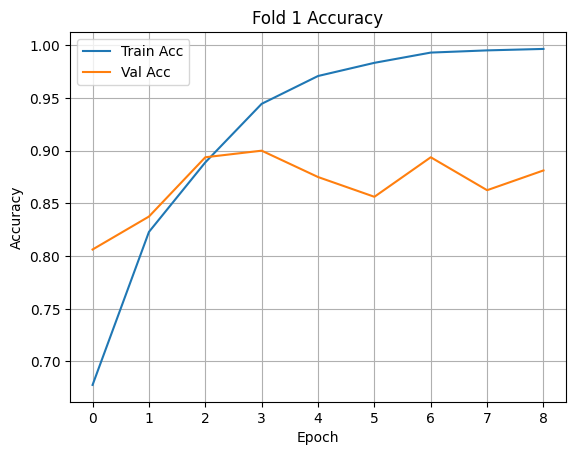

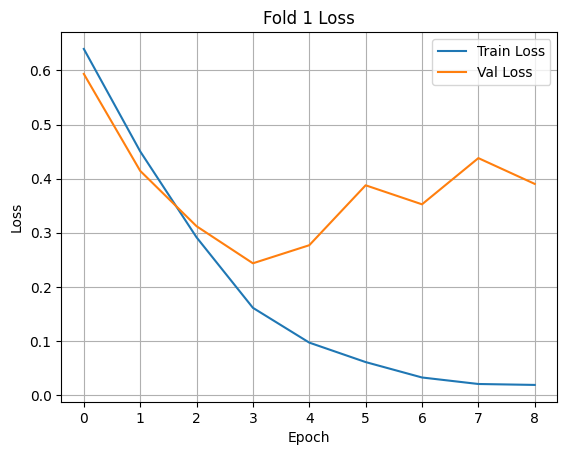

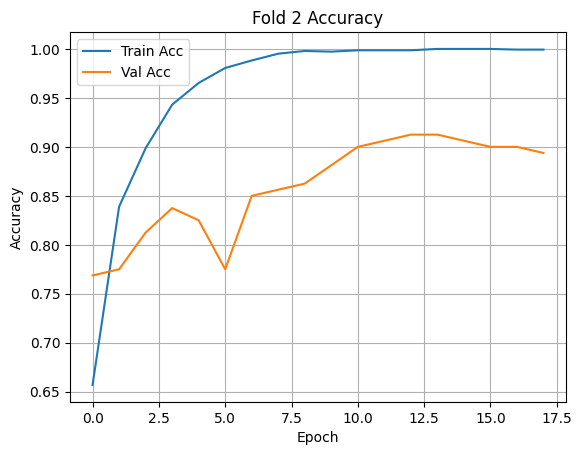

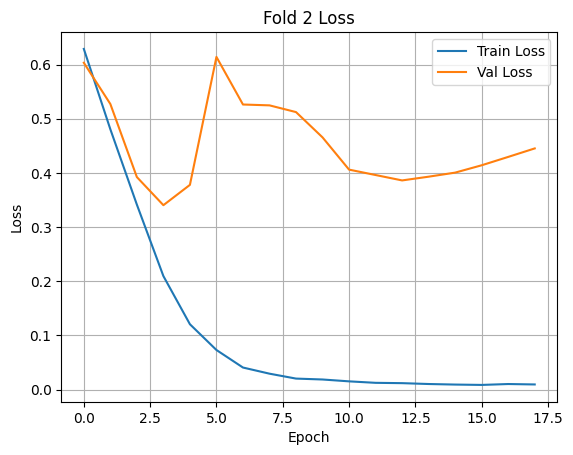

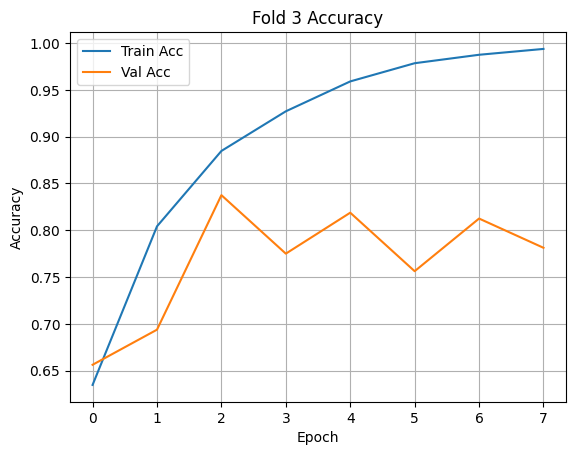

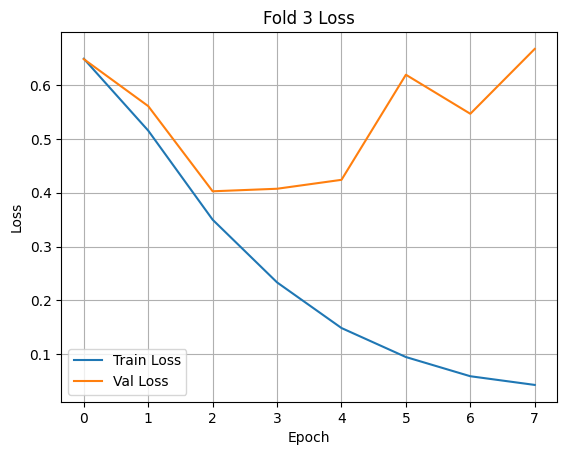

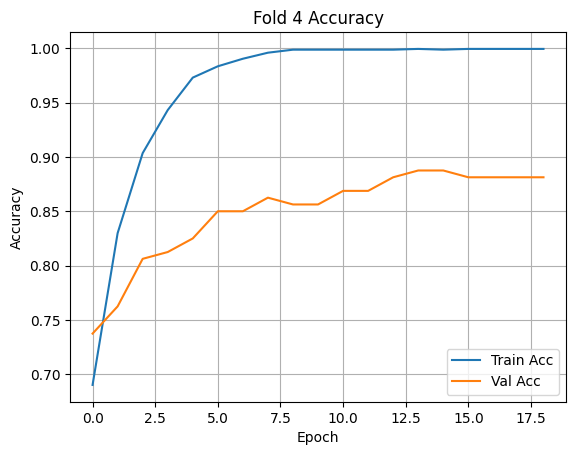

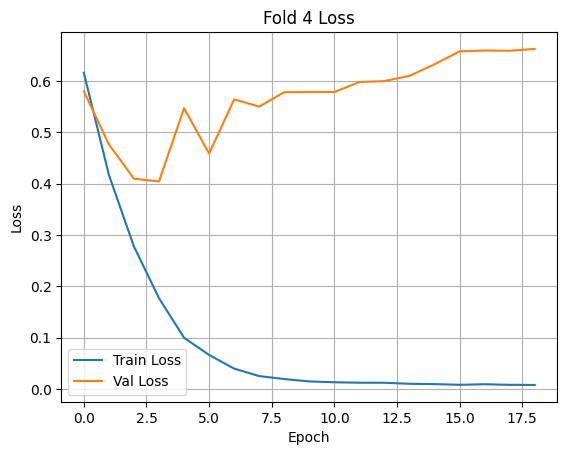

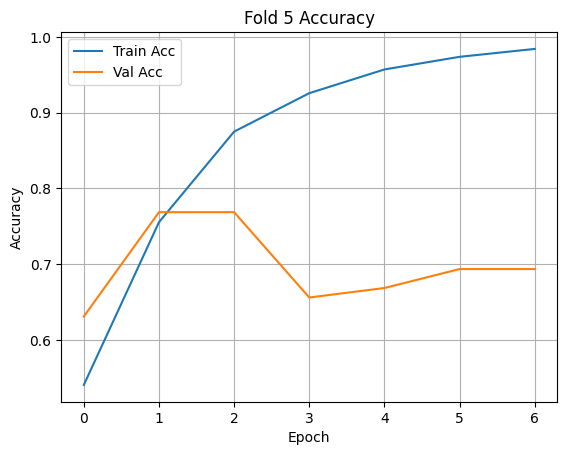

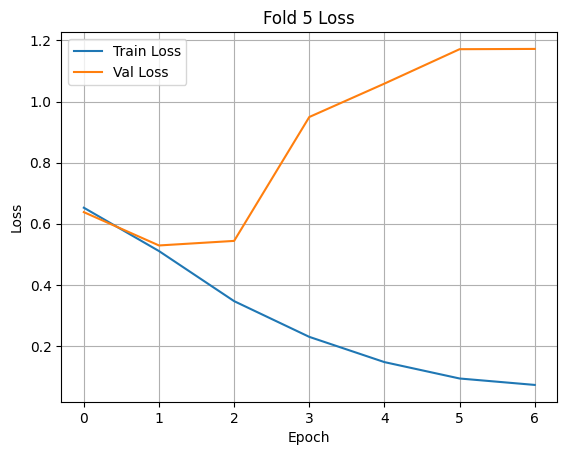

In [10]:
for i, hist in enumerate(all_histories, 1):
    plt.figure()
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
# Save mô hình fold cuối cùng
model.save("BiLSTM_Multi_Head_Attention_HMM_final.h5")

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df

📊 Kết quả trung bình:
fold         3.000000
accuracy     0.826500
precision    0.732783
recall       0.720000
f1           0.725608
auc          0.915605
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.5000,0.000000,0.000,0.000000,0.928575
1,2,0.8550,0.848039,0.865,0.856436,0.925925
2,3,1.0000,1.000000,1.000,1.000000,0.871050
3,4,0.8800,0.931818,0.820,0.872340,0.957925
4,5,0.8975,0.884058,0.915,0.899263,0.894550


In [13]:
import pandas as pd

# Giả sử results đã có và bạn đã tạo results_df
results_df = pd.DataFrame(results)

# Tính các chỉ số
accuracy_mean = results_df['accuracy'].mean()
accuracy_std = results_df['accuracy'].std()  # dùng sample std (chia cho n-1)
accuracy_range = results_df['accuracy'].max() - results_df['accuracy'].min()
accuracy_cv_percent = (accuracy_std / accuracy_mean) * 100

# In kết quả
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))

print(f"\n✅ CV Accuracy (Mean Accuracy): {accuracy_mean:.4f}")
print(f"📈 Range Accuracy: {accuracy_range:.4f}")
print(f"📉 Accuracy CV% (std/mean): {accuracy_cv_percent:.2f}%")

# Hiển thị bảng kết quả nếu cần
results_df

📊 Kết quả trung bình:
fold         3.000000
accuracy     0.826500
precision    0.732783
recall       0.720000
f1           0.725608
auc          0.915605
dtype: float64

✅ CV Accuracy (Mean Accuracy): 0.8265
📈 Range Accuracy: 0.5000
📉 Accuracy CV% (std/mean): 23.07%


,fold,accuracy,precision,recall,f1,auc
0,1,0.5000,0.000000,0.000,0.000000,0.928575
1,2,0.8550,0.848039,0.865,0.856436,0.925925
2,3,1.0000,1.000000,1.000,1.000000,0.871050
3,4,0.8800,0.931818,0.820,0.872340,0.957925
4,5,0.8975,0.884058,0.915,0.899263,0.894550
